# Quarterback Passing Yards/Game Predictive Modeling

## Importing Passer Data

In [1]:
# Import dependencies
# NFL pbp data
import nfl_data_py as nfl

# Basics / visualizations
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Machine learning tools
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

# Stats Stuff
from scipy import stats
from scipy.stats import skew
import statsmodels.api as sm


# Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)


In [2]:
schedule = nfl.import_schedules([2024])
future = schedule[schedule['week'] >= 4]


In [3]:
# Select only the relevant columns
columns = ['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards', 
           'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
           'passing_yards', 'cpoe', 'roof', 'surface']

# Loading in the NFL pbp data
data = nfl.import_pbp_data(range(2014,2025), columns, include_participation=False)

# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
data = data[columns]

# Drop all rows that are not a pass
data = data[data['play_type'] == 'pass']

# Drop the play type column
passer_data = data.drop(columns=['play_type'])

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


In [4]:
passer_data

,game_id,passer_player_name,posteam,defteam,season,week,home_team,away_team,air_yards,yards_after_catch,epa,complete_pass,incomplete_pass,interception,qb_hit,sack,pass_touchdown,passing_yards,cpoe,roof,surface
4,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,CHI,BUF,11.0,NaN,-1.542538,0.0,1.0,0.0,0.0,0.0,0.0,NaN,-63.542004,outdoors,grass
7,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,4.0,4.0,0.889353,1.0,0.0,0.0,0.0,0.0,0.0,8.0,24.549454,outdoors,grass
8,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,39.0,5.0,2.468265,1.0,0.0,0.0,0.0,0.0,0.0,44.0,71.269318,outdoors,grass
9,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,12.0,0.0,1.879388,1.0,0.0,0.0,0.0,0.0,1.0,12.0,53.646080,outdoors,grass
12,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,CHI,BUF,1.0,11.0,0.731470,1.0,0.0,0.0,0.0,0.0,0.0,12.0,19.861258,outdoors,grass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489921,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,CIN,WAS,-1.0,1.0,-0.272676,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.075715,outdoors,fieldturf
489922,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,CIN,WAS,13.0,0.0,0.936383,1.0,0.0,0.0,0.0,0.0,0.0,13.0,37.446724,outdoors,fieldturf
489924,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,CIN,WAS,29.0,NaN,-0.228033,0.0,1.0,0.0,0.0,0.0,0.0,NaN,-31.641153,outdoors,fieldturf
489925,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,CIN,WAS,13.0,0.0,1.426387,1.0,0.0,0.0,0.0,0.0,0.0,13.0,38.319050,outdoors,fieldturf


## Passer Preprocessing & Feature Engineering

In [5]:
# Group the data together by passer, week, season and aggregate
passer_df = passer_data.groupby(['game_id', 'passer_player_name', 'week', 'season'], as_index=False).agg(
    {'posteam' : 'first',
     'defteam' : 'first',
     'home_team' : 'first',
     'away_team' : 'first',
     'air_yards' : 'sum',
     'yards_after_catch' : 'sum',
     'epa' : 'sum',
     'complete_pass' : 'sum',
     'incomplete_pass' : 'sum',
     'interception' : 'sum',
     'qb_hit' : 'sum',
     'sack' : 'sum',
     'pass_touchdown' : 'sum',
     'passing_yards' : 'sum',
     'cpoe' : 'mean',
     'roof' : 'first',
     'surface' : 'first'
     }
)

In [6]:
# Create a new column that is completion percentage
passer_df['completion_percentage'] = passer_df['complete_pass'] / (passer_df['complete_pass'] + passer_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
passer_df['pass_attempts'] = passer_df['complete_pass'] + passer_df['incomplete_pass']

# Drop the complete_pass and incomplete_pass columns
passer_df = passer_df.drop(columns=['complete_pass', 'incomplete_pass'])

In [7]:
# Create a new column that equals 1 if the passer is the home team and 0 if the passer is the away team
passer_df['home_flag'] = passer_df['home_team'] == passer_df['posteam']

# Drop the home_team and away_team columns
passer_df = passer_df.drop(columns=['home_team', 'away_team'])

In [8]:
# Reorder the columns
passer_df = passer_df[['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'passing_yards', 'home_flag', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                        'cpoe', 'roof', 'surface']]

In [9]:
# Calculate the exponentially weighted moving average for each feature
passer_df['completion_percentage_ewma'] = passer_df.groupby('passer_player_name')['completion_percentage']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['pass_attempts_ewma'] = passer_df.groupby('passer_player_name')['pass_attempts']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['air_yards_ewma'] = passer_df.groupby('passer_player_name')['air_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['yards_after_catch_ewma'] = passer_df.groupby('passer_player_name')['yards_after_catch']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['epa_ewma'] = passer_df.groupby('passer_player_name')['epa']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['interception_ewma'] = passer_df.groupby('passer_player_name')['interception']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['qb_hit_ewma'] = passer_df.groupby('passer_player_name')['qb_hit']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['sack_ewma'] = passer_df.groupby('passer_player_name')['sack']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['pass_touchdown_ewma'] = passer_df.groupby('passer_player_name')['pass_touchdown']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['passing_yards_ewma'] = passer_df.groupby('passer_player_name')['passing_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['cpoe_ewma'] = passer_df.groupby('passer_player_name')['cpoe']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

In [10]:
# Drop the non-ewma columns
passer_df = passer_df.drop(columns=['completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'cpoe'])

In [11]:
passer_df

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag,pass_attempts,roof,surface,completion_percentage_ewma,pass_attempts_ewma,air_yards_ewma,yards_after_catch_ewma,epa_ewma,interception_ewma,qb_hit_ewma,sack_ewma,pass_touchdown_ewma,passing_yards_ewma,cpoe_ewma
0,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,173.0,False,21.0,outdoors,grass,0.761905,21.000000,190.000000,80.000000,0.368607,1.000000,3.000000,1.000000,1.000000,173.000000,11.150598
1,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,349.0,True,47.0,outdoors,grass,0.723404,47.000000,366.000000,190.000000,-6.755498,2.000000,4.000000,2.000000,2.000000,349.000000,2.864331
2,2014_01_CAR_TB,D.Anderson,CAR,TB,2014,1,230.0,False,33.0,outdoors,grass,0.727273,33.000000,242.000000,70.000000,8.423189,0.000000,3.000000,1.000000,2.000000,230.000000,9.822589
3,2014_01_CAR_TB,J.McCown,TB,CAR,2014,1,183.0,True,33.0,outdoors,grass,0.666667,33.000000,245.000000,45.000000,-10.437736,2.000000,9.000000,3.000000,2.000000,183.000000,0.519191
4,2014_01_CIN_BAL,A.Dalton,CIN,BAL,2014,1,301.0,False,38.0,outdoors,sportturf,0.657895,38.000000,262.000000,172.000000,11.252419,0.000000,1.000000,0.000000,1.000000,301.000000,-2.044219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6749,2024_03_SF_LA,B.Purdy,SF,LA,2024,3,292.0,False,30.0,dome,matrixturf,0.738309,31.253286,319.248695,57.281068,10.390618,0.231710,4.058320,2.192788,2.260245,292.181912,7.473561
6750,2024_03_SF_LA,M.Stafford,LA,SF,2024,3,221.0,True,25.0,dome,matrixturf,0.661731,27.515754,243.125736,98.034767,0.608555,0.090585,6.395725,3.347680,0.807042,231.750317,3.032181
6751,2024_03_SF_LA,T.Atwell,LA,SF,2024,3,0.0,True,1.0,dome,matrixturf,0.000000,0.750000,25.500000,0.000000,-0.120076,0.000000,0.000000,0.000000,0.000000,0.000000,-34.259178
6752,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,324.0,True,38.0,outdoors,fieldturf,0.729274,36.380665,257.093181,115.619849,10.899412,0.016883,4.420252,2.311366,2.494750,292.143028,7.180779


## Defense Preprocessing & Feature Engineering

In [30]:
# Select only the relevant columns
defense_columns = ['defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards',
                   'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
                   'passing_yards', 'cpoe', 'roof', 'surface']


# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
defense_data = data[defense_columns]

# Drop the play type column
defense_data = defense_data.drop(columns=['play_type'])

In [31]:
# Group the data together by passer, week, season and aggregate
defense_df = defense_data.groupby(['defteam', 'week', 'season'], as_index=False).agg(
    {'home_team': 'first',
     'away_team': 'first',
     'air_yards': 'sum',
     'yards_after_catch': 'sum',
     'epa': 'sum',
     'complete_pass': 'sum',
     'incomplete_pass': 'sum',
     'interception': 'sum',
     'qb_hit': 'sum',
     'sack': 'sum',
     'pass_touchdown': 'sum',
     'passing_yards': 'sum',
     'cpoe': 'mean',
     'roof': 'first',
     'surface': 'first'
     }
)

In [32]:
# Create a new column that is completion percentage
defense_df['completion_percentage'] = defense_df['complete_pass'] / (defense_df['complete_pass'] + defense_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
defense_df['pass_attempts'] = defense_df['complete_pass'] + defense_df['incomplete_pass']

# Drop the complete_pass and incomplete_pass columns
defense_df = defense_df.drop(columns=['complete_pass', 'incomplete_pass'])

In [33]:
# Create a new column that equals 1 if the defense is the home team and 0 if the defense is the away team
defense_df['home_flag'] = defense_df['home_team'] == defense_df['defteam']

# Drop the home_team and away_team columns
defense_df = defense_df.drop(columns=['home_team', 'away_team'])

In [34]:
# Reorder the columns
defense_df = defense_df[['defteam', 'season', 'week', 'home_flag', 'passing_yards', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                       'cpoe', 'roof', 'surface']]

In [35]:
defense_df

,defteam,season,week,home_flag,passing_yards,completion_percentage,pass_attempts,air_yards,yards_after_catch,epa,interception,qb_hit,sack,pass_touchdown,cpoe,roof,surface
0,ARI,2014,1,True,238.0,0.600000,35.0,345.0,90.0,0.799435,1.0,4.0,0.0,1.0,-6.609174,closed,grass
1,ARI,2015,1,True,355.0,0.638298,47.0,233.0,277.0,1.829823,1.0,4.0,2.0,1.0,-8.648963,closed,grass
2,ARI,2016,1,True,264.0,0.727273,33.0,210.0,142.0,13.317495,0.0,4.0,2.0,1.0,5.301393,closed,grass
3,ARI,2017,1,False,292.0,0.725000,40.0,317.0,88.0,-2.884409,1.0,4.0,1.0,4.0,5.455871,dome,fieldturf
4,ARI,2018,1,True,255.0,0.700000,30.0,101.0,180.0,9.827952,0.0,9.0,3.0,2.0,1.424664,closed,grass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5541,WAS,2015,18,True,210.0,0.583333,36.0,365.0,78.0,10.725159,0.0,2.0,1.0,2.0,1.810942,outdoors,grass
5542,WAS,2020,18,True,381.0,0.550000,40.0,461.0,119.0,19.551708,0.0,7.0,3.0,2.0,-2.638113,outdoors,grass
5543,WAS,2021,18,False,103.0,0.517241,29.0,215.0,63.0,-19.281746,2.0,8.0,3.0,1.0,-16.412041,outdoors,fieldturf
5544,WAS,2022,18,True,128.0,0.378378,37.0,401.0,35.0,-14.503402,1.0,4.0,1.0,1.0,-24.287834,outdoors,grass


In [36]:
# Calculate the exponentially weighted moving average for each feature
defense_df['completion_percentage_ewma'] = defense_df.groupby('defteam')['completion_percentage']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['pass_attempts_ewma'] = defense_df.groupby('defteam')['pass_attempts']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['air_yards_ewma'] = defense_df.groupby('defteam')['air_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['yards_after_catch_ewma'] = defense_df.groupby('defteam')['yards_after_catch']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['epa_ewma'] = defense_df.groupby('defteam')['epa']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['interception_ewma'] = defense_df.groupby('defteam')['interception']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['qb_hit_ewma'] = defense_df.groupby('defteam')['qb_hit']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['sack_ewma'] = defense_df.groupby('defteam')['sack']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['pass_touchdown_ewma'] = defense_df.groupby('defteam')['pass_touchdown']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['passing_yards_ewma'] = defense_df.groupby('defteam')['passing_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['cpoe_ewma'] = defense_df.groupby('defteam')['cpoe']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

In [37]:
# Drop the non-ewma columns
defense_df = defense_df.drop(columns=['passing_yards','completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'pass_attempts', 'cpoe'])

## Merging Passer & Defense Data

In [39]:
# Merge the defense and passer dataframes together
full_with_ewma = passer_df.merge(defense_df, how='inner', on=['defteam', 'season', 'week', 'roof', 'surface'], suffixes=('_passer', '_defense'))
# Get rid of flukey rows. Jury out on Taysom Hill I guess.
filtered_with_ewma = full_with_ewma[(full_with_ewma['pass_attempts'] > 8)]

filtered_with_ewma[(filtered_with_ewma['season'] == 2024) & (filtered_with_ewma['week'] == 3)]

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag_passer,pass_attempts,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
6712,2024_03_BAL_DAL,D.Prescott,DAL,BAL,2024,3,379.0,True,51.0,closed,matrixturf,0.604197,46.237290,431.716673,140.503430,-1.413600,0.505107,5.661311,3.000900,1.744306,344.545502,-7.204234,False,0.585070,47.183888,433.423249,128.673365,-0.937931,0.223481,6.508377,3.388698,1.598253,336.729203,-7.207644
6713,2024_03_BAL_DAL,L.Jackson,BAL,DAL,2024,3,182.0,False,15.0,closed,matrixturf,0.753774,21.098289,124.772288,139.164914,6.965681,0.247328,1.410834,0.647781,1.020332,205.617049,2.554606,True,0.778804,18.733578,91.688669,139.851582,6.936386,0.123487,2.645615,0.909154,0.982177,189.443570,4.695163
6714,2024_03_CAR_LV,A.Dalton,CAR,LV,2024,3,319.0,False,37.0,dome,grass,0.536241,30.042043,186.768589,140.354218,8.187531,0.011002,3.542427,1.632309,2.175094,245.809933,-17.979084,True,0.674213,34.316313,218.881956,166.997534,10.394677,0.082546,4.343830,1.696997,2.534152,292.024282,-3.560846
6715,2024_03_CAR_LV,A.O'Connell,LV,CAR,2024,3,82.0,True,12.0,dome,grass,0.713639,19.077115,151.185481,46.261945,6.625955,0.003775,2.859390,1.329704,1.293516,135.412216,5.129469,False,0.681550,37.883543,319.104467,132.125246,2.600404,1.054452,6.515557,2.658086,1.670914,297.018022,-0.716835
6716,2024_03_CAR_LV,G.Minshew,LV,CAR,2024,3,214.0,True,27.0,dome,grass,0.703652,29.516534,218.395746,113.111220,-3.507767,0.966059,5.161345,2.794162,0.974452,229.226681,-1.007976,False,0.681550,37.883543,319.104467,132.125246,2.600404,1.054452,6.515557,2.658086,1.670914,297.018022,-0.716835
6717,2024_03_CHI_IND,A.Richardson,IND,CHI,2024,3,167.0,True,18.0,closed,fieldturf,0.557984,20.571821,250.199451,87.434584,-8.768255,2.075938,2.873742,1.082342,0.387923,176.874657,-9.228116,False,0.609356,23.411520,214.874673,107.548234,-4.272145,1.945153,3.546961,0.896388,0.781436,206.044953,-5.241558
6718,2024_03_CHI_IND,C.Williams,CHI,IND,2024,3,363.0,False,49.0,closed,fieldturf,0.655032,44.230769,455.384615,117.000000,-10.971047,1.846154,6.076923,4.538462,1.384615,298.615385,0.065786,True,0.675472,43.122133,432.360609,116.629581,-7.552034,1.486145,4.719495,3.676017,1.499564,313.733728,1.557765
6719,2024_03_DEN_TB,B.Mayfield,TB,DEN,2024,3,163.0,True,32.0,outdoors,grass,0.752427,28.945951,136.613096,112.115736,-14.455518,0.940117,7.642336,5.994791,1.286885,183.367934,1.683907,False,0.789033,30.885389,150.046314,129.732635,-9.650523,0.790304,6.946786,5.106519,1.880874,215.244389,6.017196
6720,2024_03_DEN_TB,B.Nix,DEN,TB,2024,3,216.0,False,36.0,outdoors,grass,0.670629,35.615385,267.000000,102.615385,-2.130000,0.615385,3.615385,0.615385,0.000000,216.923077,2.029838,True,0.693740,35.686146,266.795489,113.682318,2.210107,0.536052,2.889914,0.386989,0.486784,236.188093,4.495491
6721,2024_03_DET_ARI,J.Goff,DET,ARI,2024,3,199.0,False,22.0,closed,grass,0.764137,29.706414,226.486731,100.791028,0.804755,1.185819,4.109785,1.556998,1.453730,227.239767,5.682186,True,0.767565,26.317206,190.920710,103.141717,3.613105,0.939424,2.829072,1.967892,1.608307,215.065595,6.994946


## Removing Outliers

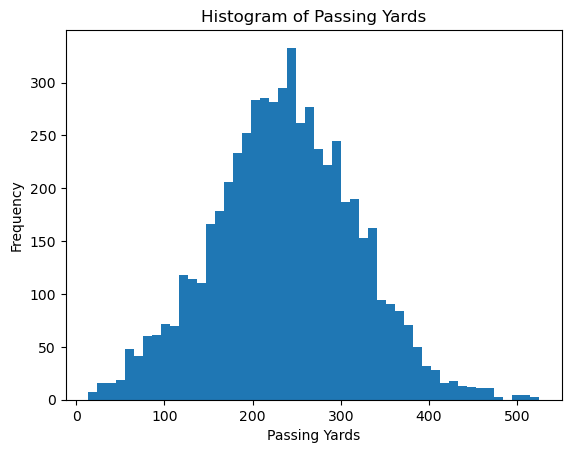

In [20]:
# Identify distribution shape to recreate after we get model results. This looks normal so using our projection for each QB for a week we will use RMSE
# as the standard deviation to create a normal distribution and assign a likelihood to each 
plt.hist(filtered_with_ewma['passing_yards'], bins=50)  # You can adjust the number of bins
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.title('Histogram of Passing Yards')
plt.show()

## Exploratory Data Analysis

In [21]:
# Get an overview of the data
filtered_with_ewma.describe().round(2)

,season,week,passing_yards,pass_attempts,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
count,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00
mean,2018.68,9.51,236.79,32.16,0.66,31.83,264.05,108.46,0.90,0.75,5.05,2.22,1.46,234.67,0.19,0.66,33.75,280.63,114.52,0.55,0.83,5.41,2.39,1.53,247.68,0.22
std,2.95,5.44,81.26,9.17,0.08,7.51,79.37,36.97,8.03,0.65,2.17,1.27,0.89,66.64,7.01,0.07,5.83,69.62,31.45,7.99,0.68,2.03,1.26,0.82,53.63,6.24
min,2014.00,1.00,14.00,9.00,0.22,6.89,15.00,5.80,-29.73,0.00,0.00,0.00,0.00,22.00,-39.47,0.36,13.93,91.69,31.91,-27.07,0.00,0.00,0.00,0.00,81.57,-28.19
25%,2016.00,5.00,183.00,26.00,0.61,27.23,210.33,83.29,-4.45,0.23,3.49,1.26,0.82,192.20,-4.07,0.61,29.69,231.55,92.29,-4.66,0.25,3.97,1.47,0.92,209.60,-3.79
50%,2019.00,10.00,236.00,32.00,0.66,32.07,260.96,106.76,0.73,0.69,4.83,2.05,1.37,235.58,0.46,0.66,33.49,275.61,111.19,0.85,0.73,5.21,2.24,1.47,245.15,0.30
75%,2021.00,14.00,291.00,38.00,0.71,36.75,314.78,132.32,6.41,1.11,6.39,2.95,2.00,279.99,4.91,0.70,37.47,323.81,134.08,6.04,1.22,6.68,3.13,2.05,283.49,4.47
max,2024.00,22.00,525.00,67.00,1.00,61.00,603.72,250.26,26.29,4.15,14.94,8.25,5.52,483.02,23.10,0.89,61.00,627.07,244.09,27.12,4.01,14.39,8.42,4.96,458.00,20.70


## Modeling w/ Sci-kit Learn

maybe come back to the below cell and figure out how to transform these features into numerical values

In [22]:
# Define the target and features
target = 'passing_yards'
features = filtered_with_ewma.columns.drop(['pass_attempts', 'passer_player_name', 'passing_yards', 'posteam', 'defteam', 'season', 'week', 'game_id'])

In [23]:
# #running on everything to get best params, once I get params take them adn make new model holding out 
# X = filtered_with_ewma.loc[filtered_with_ewma['season'] != 2024, features]
# y = filtered_with_ewma.loc[filtered_with_ewma['season'] != 2024, target]

# # Select columns for one-hot encoding and standard scaling
# categorical_columns = ['roof', 'surface']
# numeric_columns = [item for item in X.columns if item not in ['roof', 'surface']]

# # Create a column transformer for preprocessing (OHE for categorical, SS for numeric)
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(), categorical_columns),
#         ('num', StandardScaler(), numeric_columns)
#     ])

# # Define the parameter grid for tuning
# param_grid = {
#     'num_leaves': [10, 20, 30, 40, 50],
#     'learning_rate': [0.01, 0.03, 0.05, 0.1],
#     'max_depth': [-1, 5, 10, 15],
#     'min_data_in_leaf': [10, 20, 30, 50, 100],
#     'min_split_gain': [0.0, 0.1, 0.2],
#     'subsample_for_bin': [20000, 30000, 40000],
#     'subsample': [0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'bagging_fraction': [0.7, 0.8, 0.9],
#     'feature_fraction': [0.7, 0.8, 0.9],
#     'lambda_l1': [0, 0.1, 0.5, 1],
#     'lambda_l2': [0, 0.1, 0.5, 1],
#     'scale_pos_weight': [1, 10, 20],  # for imbalanced datasets
#     'objective': ['regression'],
#     'boosting_type': ['gbdt', 'dart', 'goss'],  # try different boosting types
#     'n_estimators': [500, 1000, 1500],
#     'metric': ['rmse']
# }

# # Instantiate the LGBM model
# model = lgb.LGBMRegressor(boosting_type='gbdt', random_state=42)

# # Define the pipeline with preprocessing and the model
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', model)
# ])

# # Set up Bayesian Search using the pipeline
# opt = BayesSearchCV(
#     estimator=pipeline,  # Use the pipeline in Bayesian optimization
#     search_spaces={'regressor__' + k: v for k, v in param_grid.items()},  # Prefix params with 'regressor__'
#     n_iter=50,  # Number of iterations for Bayesian optimization
#     cv=3,
#     random_state=42,
#     verbose=1,
#     n_jobs=-1  # Use parallel processing
# )

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Fit the Bayesian optimization search
# opt.fit(X_train, y_train)

# # Get the best parameters
# best_params = opt.best_params_

# # Save best parameters as a dictionary (without 'regressor__' prefix)
# cleaned_best_params = {k.replace('regressor__', ''): v for k, v in best_params.items()}

In [24]:
# Define the best parameters from Bayesian optimization
best_params = {
    'bagging_fraction': 0.7,
    'boosting_type': 'goss',
    'colsample_bytree': 0.9,
    'feature_fraction': 0.8,
    'lambda_l1': 1,
    'lambda_l2': 0,
    'learning_rate': 0.01,
    'max_depth': 5,
    'metric': 'rmse',
    'min_data_in_leaf': 10,
    'min_split_gain': 0.2,
    'n_estimators': 1000,
    'num_leaves': 10,
    'objective': 'regression',
    # 'scale_pos_weight': 10,
    'subsample': 0.9,
    'subsample_for_bin': 30000
}


In [25]:
# # Example: Setting quantile regression with a 50% (median) target
# best_params = {
#     'boosting_type': 'goss',
#     'objective': 'quantile',
#     'alpha': 0.5,  # Predict the median
#     'learning_rate': 0.01,
#     'n_estimators': 1000,
#     'num_leaves': 10,
#     'min_data_in_leaf': 10,
#     'max_depth': 5,
#     'metric': 'quantile'
# }

In [26]:
# Use data for all seasons before 2023 for training
X = filtered_with_ewma.loc[filtered_with_ewma['season'] <= 2023, features]
y = filtered_with_ewma.loc[filtered_with_ewma['season'] <= 2023, target]

In [27]:
# The data for 2024 that we will hold out for final testing
X_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, features]
y_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, target]

In [28]:
# Ensure there are no missing values in X or y
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Select columns for one-hot encoding and standard scaling
categorical_columns = ['roof', 'surface']
numeric_columns = [item for item in X.columns if item not in ['roof', 'surface']]

# Create a column transformer for preprocessing (OHE for categorical, SS for numeric)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ])

# Instantiate the LGBM model with the best parameters
model = lgb.LGBMRegressor(**best_params, random_state=42, verbosity=-1)

# Define the pipeline with preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Fit the model to all the data through 2023
pipeline.fit(X, y)

# Evaluate the model on the 2024 data
y_pred_2024 = pipeline.predict(X_2024)

# Print results (e.g., performance metrics)
print(f"2024 set performance: RMSE = {mean_squared_error(y_2024, y_pred_2024, squared=False)}")

2024 set performance: RMSE = 19.15609458740184


In [29]:
y_train_pred = pipeline.predict(X)
train_rmse = mean_squared_error(y, y_train_pred, squared=False)
print(f"Training RMSE: {train_rmse}")

y_test_pred = pipeline.predict(X_2024)
test_rmse = mean_squared_error(y_2024, y_test_pred, squared=False)
print(f"Test RMSE: {test_rmse}")

#holy fuck boss I'm not overfitting and it's a good model

Training RMSE: 18.676584039841348
Test RMSE: 19.15609458740184


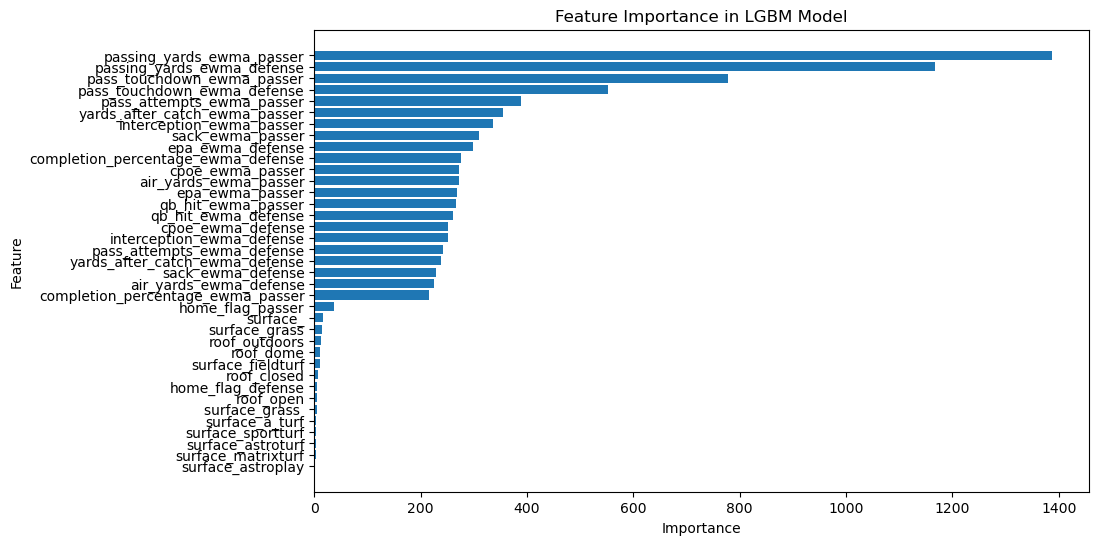

In [30]:
# Get the trained LGBMRegressor model from the pipeline
lgbm_model = pipeline.named_steps['regressor']

# Get feature names after preprocessing
categorical_features = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_columns)
numeric_features = numeric_columns  # These don't change from preprocessing

# Combine the categorical and numeric feature names
all_features = list(categorical_features) + numeric_features

# Extract feature importances from the LGBM model
feature_importances = lgbm_model.feature_importances_

# Create a DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Optional: Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in LGBM Model')
plt.gca().invert_yaxis()
plt.show()

In [107]:
feature_importance_df['Feature']

23             passing_yards_ewma_passer
35            passing_yards_ewma_defense
22            pass_touchdown_ewma_passer
34           pass_touchdown_ewma_defense
15             pass_attempts_ewma_passer
17         yards_after_catch_ewma_passer
19              interception_ewma_passer
21                      sack_ewma_passer
30                      epa_ewma_defense
26    completion_percentage_ewma_defense
24                      cpoe_ewma_passer
16                 air_yards_ewma_passer
18                       epa_ewma_passer
20                    qb_hit_ewma_passer
32                   qb_hit_ewma_defense
36                     cpoe_ewma_defense
31             interception_ewma_defense
27            pass_attempts_ewma_defense
29        yards_after_catch_ewma_defense
33                     sack_ewma_defense
28                air_yards_ewma_defense
14     completion_percentage_ewma_passer
13                      home_flag_passer
4                               surface_
9               

In [31]:
# Adding identifier columns back after filtering for 2024 data
X_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, features]
X_2024 = X_2024.merge(filtered_with_ewma[['game_id', 'passer_player_name', 'posteam', 'week']], left_index=True, right_index=True)

In [32]:
# Assuming you have a column like 'game_id' that identifies each game
game_id_column = 'game_id'
passer_column = 'passer_player_name'
team_column = 'posteam'
week_column = 'week'

# Preprocess the 2024 data using the pipeline (no need to use 'preprocessor' step directly)
y_pred_2024 = pipeline.predict(X_2024)

# Create a DataFrame to store predictions along with the game identifier
pred_df = pd.DataFrame({
    game_id_column: X_2024[game_id_column].values,
    passer_column: X_2024[passer_column].values,            # Passer name (QB)
    team_column: X_2024[team_column].values,  # Get the game IDs from X_2024
    week_column: X_2024[week_column].values,  #Week
    'true_passing_yards': y_2024.values,                     # Actual target values
    'predicted_passing_yards': y_pred_2024                   # Predicted values
})

pred_df['pass_yards_oe'] = pred_df['true_passing_yards'] - pred_df['predicted_passing_yards']

In [33]:
pred_df.sort_values('pass_yards_oe', ascending = False)

,game_id,passer_player_name,posteam,week,true_passing_yards,predicted_passing_yards,pass_yards_oe
92,2024_03_NYG_CLE,D.Jones,NYG,3,236.0,193.225352,42.774648
90,2024_03_NE_NYJ,A.Rodgers,NYJ,3,281.0,239.993807,41.006193
67,2024_03_CAR_LV,A.Dalton,CAR,3,319.0,280.241614,38.758386
24,2024_01_NYJ_SF,A.Rodgers,NYJ,1,167.0,130.451047,36.548953
71,2024_03_CHI_IND,C.Williams,CHI,3,363.0,328.505959,34.494041
...,...,...,...,...,...,...,...
78,2024_03_HOU_MIN,C.Stroud,HOU,3,215.0,251.853971,-36.853971
69,2024_03_CAR_LV,G.Minshew,LV,3,214.0,251.794327,-37.794327
63,2024_02_TB_DET,B.Mayfield,TB,2,185.0,225.122614,-40.122614
68,2024_03_CAR_LV,A.O'Connell,LV,3,82.0,125.826550,-43.826550


In [34]:
pred_df.shape

(100, 7)

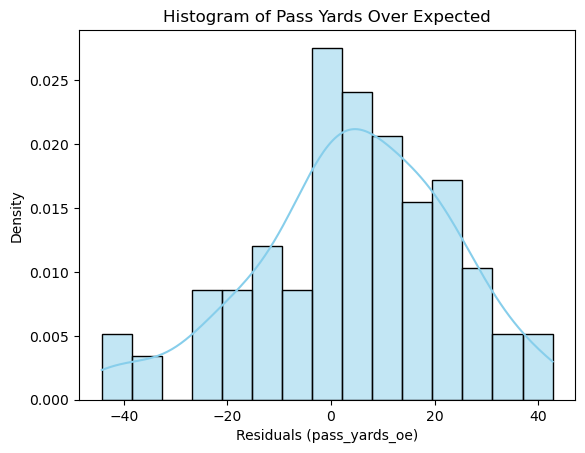

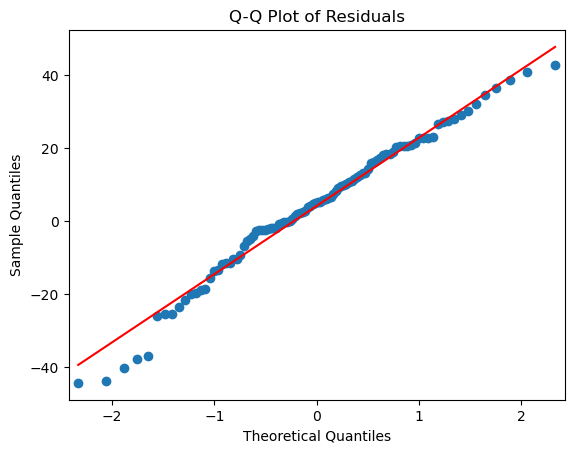

In [35]:
# Assuming 'residuals' is your numpy array of pass_yards_oe
residuals = pred_df['pass_yards_oe'].values

# Histogram and KDE
sns.histplot(residuals, bins=15, kde=True, stat='density', color='skyblue')
plt.title('Histogram of Pass Yards Over Expected')
plt.xlabel('Residuals (pass_yards_oe)')
plt.ylabel('Density')
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [36]:
# Fit Normal Distribution
mu_norm, sigma_norm = stats.norm.fit(residuals)

# Fit Student's t-Distribution
df_t, loc_t, scale_t = stats.t.fit(residuals)

# Fit Skew-Normal Distribution
shape_skew, loc_skew, scale_skew = stats.skewnorm.fit(residuals)

# Fit Laplace Distribution
loc_laplace, scale_laplace = stats.laplace.fit(residuals)

In [37]:
def calculate_aic(n_params, log_likelihood):
    return 2 * n_params - 2 * log_likelihood

def calculate_bic(n_params, log_likelihood, n_samples):
    return np.log(n_samples) * n_params - 2 * log_likelihood

n = len(residuals)

# Normal Distribution
loglik_norm = np.sum(stats.norm.logpdf(residuals, mu_norm, sigma_norm))
aic_norm = calculate_aic(2, loglik_norm)
bic_norm = calculate_bic(2, loglik_norm, n)

# t-Distribution
loglik_t = np.sum(stats.t.logpdf(residuals, df_t, loc_t, scale_t))
aic_t = calculate_aic(3, loglik_t)
bic_t = calculate_bic(3, loglik_t, n)

# Skew-Normal Distribution
loglik_skew = np.sum(stats.skewnorm.logpdf(residuals, shape_skew, loc_skew, scale_skew))
aic_skew = calculate_aic(3, loglik_skew)
bic_skew = calculate_bic(3, loglik_skew, n)

# Laplace Distribution
loglik_laplace = np.sum(stats.laplace.logpdf(residuals, loc_laplace, scale_laplace))
aic_laplace = calculate_aic(2, loglik_laplace)
bic_laplace = calculate_bic(2, loglik_laplace, n)

# Compare AIC and BIC
print('AIC Values:')
print(f'Normal: {aic_norm}, t-Distribution: {aic_t}, Skew-Normal: {aic_skew}, Laplace: {aic_laplace}')

print('BIC Values:')
print(f'Normal: {bic_norm}, t-Distribution: {bic_t}, Skew-Normal: {bic_skew}, Laplace: {bic_laplace}')

#lower is better for both

AIC Values:
Normal: 873.3868319027076, t-Distribution: 875.3672625567881, Skew-Normal: 872.0223460100375, Laplace: 878.6470311533138
BIC Values:
Normal: 878.5971722746838, t-Distribution: 883.1827731147524, Skew-Normal: 879.8378565680018, Laplace: 883.85737152529


In [38]:
from scipy.stats import skew

skewness = skew(residuals)
print(f'Skewness of residuals: {skewness}')

Skewness of residuals: -0.4252762277706582


In [39]:
# Example to calculate residual standard deviation for each QB
def calculate_qb_std(pred_df):
    """
    Calculates the standard deviation of residuals for each quarterback.
    :param pred_df: DataFrame with residuals calculated.
    :return: DataFrame with added 'residual_std' for each QB.
    """
    qb_groups = pred_df.groupby('passer_player_name')['pass_yards_oe']
    pred_df['residual_std'] = qb_groups.transform('std')  # Standard deviation for each QB
    return pred_df

#Assign
pred_df = calculate_qb_std(pred_df)

In [40]:
# Calculate the standard deviation of the residuals
residual_std = np.std(pred_df['pass_yards_oe'], ddof=1)  # ddof=1 ensures it's the sample standard deviation
print(f"Standard Deviation of Residuals: {residual_std}")

Standard Deviation of Residuals: 18.784288347694403


In [41]:
pred_df['residual_std_total'] = residual_std

In [42]:
# pred_df[pred_df['passer_player_name']== 'G.Minshew']

In [43]:
# Filter the DataFrame for the most recent week
most_recent_week = pred_df['week'].max()
recent_week_df = pred_df[pred_df['week'] == most_recent_week] 

recent_week_df

,game_id,passer_player_name,posteam,week,true_passing_yards,predicted_passing_yards,pass_yards_oe,residual_std,residual_std_total
65,2024_03_BAL_DAL,D.Prescott,DAL,3,379.0,372.931763,6.068237,18.947881,18.784288
66,2024_03_BAL_DAL,L.Jackson,BAL,3,182.0,183.955143,-1.955143,5.843113,18.784288
67,2024_03_CAR_LV,A.Dalton,CAR,3,319.0,280.241614,38.758386,NaN,18.784288
68,2024_03_CAR_LV,A.O'Connell,LV,3,82.0,125.826550,-43.826550,NaN,18.784288
69,2024_03_CAR_LV,G.Minshew,LV,3,214.0,251.794327,-37.794327,23.824280,18.784288
70,2024_03_CHI_IND,A.Richardson,IND,3,167.0,158.832498,8.167502,12.034200,18.784288
71,2024_03_CHI_IND,C.Williams,CHI,3,363.0,328.505959,34.494041,20.167349,18.784288
72,2024_03_DEN_TB,B.Mayfield,TB,3,163.0,184.672578,-21.672578,22.672505,18.784288
73,2024_03_DEN_TB,B.Nix,DEN,3,216.0,229.623478,-13.623478,16.101758,18.784288
74,2024_03_DET_ARI,J.Goff,DET,3,199.0,210.578797,-11.578797,11.464527,18.784288


In [44]:
def map_std_to_df(standard_deviation):
    """
    Maps the standard deviation of QB's passing performance to degrees of freedom for the t-distribution.
    :param standard_deviation: The standard deviation of the QB's passing yards or residuals.
    :return: Degrees of freedom (df) for the t-distribution.
    """
    # Example mapping logic
    if standard_deviation > 50:
        return 3  # Very high variance, allow more extreme outcomes
    elif 30 < standard_deviation <= 50:
        return 5  # High variance, some extreme outcomes possible
    elif 20 < standard_deviation <= 30:
        return 7  # Moderate variance
    else:
        return 10  # Low variance, tighter distribution

In [45]:
def get_qb_std(qb_name, pred_df):
    """
    Retrieves the standard deviation of the QB's residuals or passing yards from pred_df.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param pred_df: DataFrame containing predicted passing yards and residuals.
    :return: The standard deviation for the given QB.
    """
    # Ensure the QB exists in the dataframe
    if qb_name not in pred_df['passer_player_name'].values:
        raise ValueError(f"Quarterback {qb_name} not found in pred_df.")
    
    # Get the QB's standard deviation from residuals or passing yards
    qb_data = pred_df[pred_df['passer_player_name'] == qb_name].iloc[0]
    qb_std = qb_data['residual_std']  # Assuming residual_std column is already in pred_df
    
    # Print the standard deviation for debugging purposes
    print(f"Standard deviation for {qb_name}: {qb_std}")
    
    return qb_std

In [46]:
def calculate_league_wide_std(pred_df):
    """
    Calculates the standard deviation of true passing yards across the entire league.
    :param pred_df: DataFrame containing true passing yards.
    :return: League-wide standard deviation of true passing yards.
    """
    league_wide_std = pred_df['true_passing_yards'].std(ddof=1)  # Sample standard deviation (ddof=1)
    print(f"League-wide standard deviation of true passing yards: {league_wide_std:.2f}")
    return league_wide_std

In [47]:

# def print_all_qb_std(pred_df):
#     """
#     Prints the standard deviation of the QB's residuals or passing yards from pred_df for all quarterbacks.
#     :param pred_df: DataFrame containing predicted passing yards and residuals for each QB.
#     """
#     for index, row in pred_df.iterrows():
#         qb_name = row['passer_player_name']
#         qb_std = row['residual_std']
#         print(f"Standard deviation for {qb_name}: {qb_std}")

# # Assuming pred_df is available and has 'passer_player_name' and 'residual_std' columns.
# # Uncomment and run the function below once pred_df is defined in your environment.
# print_all_qb_std(pred_df)

In [48]:
# def simulate_passing_yards_with_limits(qb_name, pred_df, min_yards=100, max_yards=450, scaling_factor=1.2, num_simulations=10000):
#     """
#     Simulates passing yards using a t-distribution with degrees of freedom based on the QB's standard deviation,
#     applies limits to the minimum and maximum passing yards, and scales the standard deviation to widen the curve.
#     :param qb_name: The quarterback's name (e.g., "P.Mahomes").
#     :param pred_df: DataFrame containing predicted passing yards and residual standard deviation for each QB.
#     :param min_yards: Minimum passing yards limit.
#     :param max_yards: Maximum passing yards limit.
#     :param scaling_factor: Factor to scale the residual standard deviation to widen the curve.
#     :param num_simulations: Number of simulations to run.
#     :return: Simulated passing yards, predicted passing yards, residual std, and degrees of freedom.
#     """
#     # Retrieve the QB's standard deviation
#     qb_std = get_qb_std(qb_name, pred_df)
    
#     # Map the standard deviation to degrees of freedom
#     df = map_std_to_df(qb_std)
    
#     # Extract the predicted passing yards and residual standard deviation for the QB
#     qb_data = pred_df[pred_df['passer_player_name'] == qb_name].iloc[0]
#     predicted_passing_yards = qb_data['predicted_passing_yards']
#     residual_std = qb_data['residual_std']
    
#     # Scale the standard deviation to widen the distribution
#     scaled_std = residual_std * scaling_factor
    
#     # Simulate passing yards using the t-distribution with dynamically adjusted df
#     simulations = stats.t.rvs(df, loc=predicted_passing_yards, scale=scaled_std, size=num_simulations)
    
#     # Apply minimum and maximum passing yards limits
#     simulations = np.clip(simulations, min_yards, max_yards)
    
#     return simulations, predicted_passing_yards, scaled_std, df

# def plot_qb_simulation_curve_with_guess_and_limits(qb_name, pred_df, user_guess=None, min_yards=100, max_yards=450, scaling_factor=1.2, num_simulations=10000):
#     """
#     Plots the distribution (curve) of simulated passing yards for a given QB, adds minimum and maximum passing yards limits,
#     and calculates the probability of exceeding the user_guess yards. Adds the prediction line and the guess line.
#     :param qb_name: The quarterback's name (e.g., "P.Mahomes").
#     :param pred_df: DataFrame containing predicted passing yards and residual standard deviation for each QB.
#     :param user_guess: Optional user guess for passing yards to plot on the curve and calculate probability.
#     :param min_yards: Minimum passing yards limit.
#     :param max_yards: Maximum passing yards limit.
#     :param scaling_factor: Factor to scale the residual standard deviation to widen the curve.
#     :param num_simulations: Number of simulations to run.
#     """
#     # Get the simulated passing yards, prediction, scaled residual std, and df for the QB
#     simulations, predicted_passing_yards, scaled_std, df = simulate_passing_yards_with_limits(qb_name, pred_df, min_yards, max_yards, scaling_factor, num_simulations)
    
#     # Print the degrees of freedom used for this QB
#     print(f"Degrees of freedom (df) for {qb_name}: {df}")
    
#     # Plot the distribution of the simulated passing yards
#     plt.figure(figsize=(10, 6))
#     sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
#     # Add the predicted passing yards line
#     plt.axvline(predicted_passing_yards, color='green', linestyle='-', label=f"Prediction: {predicted_passing_yards:.1f} yards")
    
#     # Add the user guess line and calculate the probability
#     probability = None
#     if user_guess is not None:
#         plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
#         # Calculate the probability of exceeding the user guess
#         probability = np.mean(simulations >= user_guess)
#         print(f"Probability of {qb_name} throwing at least {user_guess} yards: {probability:.4f}")
    
#     # Plot details
#     plt.title(f"Simulated Passing Yards for {qb_name} (Limits: {min_yards}-{max_yards} yards)")
#     plt.xlabel("Passing Yards")
#     plt.ylabel("Density")
#     plt.legend()
#     plt.grid(True)
#     plt.show()
    
#     return simulations, probability

# # Usage example:
# if __name__ == "__main__":
#     qb_name = "P.Mahomes"  # Example quarterback name
#     user_guess = 320  # Example user guess for passing yards
    
#     # Plot the curve for Mahomes with t-distribution, scaled std, and limits
#     simulations, probability = plot_qb_simulation_curve_with_guess_and_limits(qb_name, pred_df, user_guess=user_guess)
    
#     if probability is not None:
#         print(f"The probability of {qb_name} throwing at least {user_guess} yards is {probability:.4f}")

In [49]:
# def simulate_passing_yards_nfl_trend(qb_name, week, pred_df, league_wide_std, num_simulations=10000, normal_weight=0.7):
#     """
#     Simulates passing yards using a combination of normal distribution and t-distribution
#     with adjusted NFL trends for realistic sportsbook odds.
#     :param qb_name: The quarterback's name (e.g., "P.Mahomes").
#     :param week: The week of the simulation.
#     :param pred_df: DataFrame containing predicted passing yards for each QB.
#     :param league_wide_std: League-wide standard deviation of true passing yards.
#     :param num_simulations: Number of simulations to run.
#     :param normal_weight: Weighting of normal distribution near the center (0.0 to 1.0).
#     :return: Simulated passing yards, predicted passing yards, and degrees of freedom.
#     """
#     # Filter for the specific QB and week
#     qb_data = pred_df[(pred_df['passer_player_name'] == qb_name) & (pred_df['week'] == week)]
    
#     if qb_data.empty:
#         print(f"No data found for {qb_name} in week {week}.")
#         return None, None, None
    
#     qb_data = qb_data.iloc[0]
#     predicted_passing_yards = qb_data['predicted_passing_yards']
#     residual_std = qb_data['residual_std']  # Use QB-specific standard deviation of residuals
    
#     # Set degrees of freedom for t-distribution based on NFL passing trends
#     # High degrees of freedom for most QBs (10-15) for smoother tails
#     if residual_std < 25:
#         df = 15  # Lower variability, more consistent QB
#     elif residual_std < 50:
#         df = 10  # Moderate variability
#     else:
#         df = 7   # High variability, bigger tails
    
#     print(f"Degrees of freedom (df) for {qb_name}: {df}")
    
#     # Expand the standard deviation to widen the curve for more realistic odds
#     expanded_std = residual_std * 9  # Adjust for a wider range of realistic NFL outcomes
    
#     # Generate normal distribution simulations for values near the predicted passing yards
#     normal_simulations = np.random.normal(loc=predicted_passing_yards, scale=expanded_std, size=num_simulations)
    
#     # Generate t-distribution simulations for tail values
#     t_distribution_simulations = stats.t.rvs(df, loc=predicted_passing_yards, scale=league_wide_std, size=num_simulations)
    
#     # Combine the two distributions, with a smooth weighting between them
#     combined_simulations = np.where(np.abs(normal_simulations - predicted_passing_yards) <= expanded_std, 
#                                     normal_simulations * normal_weight + t_distribution_simulations * (1 - normal_weight),
#                                     t_distribution_simulations)
    
#     # Clip negative values (set minimum passing yards to 0 or reasonable floor)
#     combined_simulations = np.clip(combined_simulations, 0, np.inf)
    
#     return combined_simulations, predicted_passing_yards, df

# def plot_qb_simulation_nfl_trend(qb_name, week, pred_df, league_wide_std, user_guess=None, num_simulations=10000, normal_weight=0.7):
#     """
#     Plots the distribution (curve) of simulated passing yards based on NFL trends for sportsbook-like odds.
#     :param qb_name: The quarterback's name (e.g., "P.Mahomes").
#     :param week: The week of the simulation.
#     :param pred_df: DataFrame containing predicted passing yards and residuals for each QB.
#     :param league_wide_std: League-wide standard deviation of true passing yards.
#     :param user_guess: Optional user guess for passing yards to plot on the curve and calculate probability.
#     :param num_simulations: Number of simulations to run.
#     :param normal_weight: Weighting of normal distribution near the center (0.0 to 1.0).
#     """
#     # Get the simulated passing yards, predicted passing yards, and degrees of freedom for the QB and week
#     simulations, predicted_passing_yards, df = simulate_passing_yards_nfl_trend(qb_name, week, pred_df, league_wide_std, num_simulations, normal_weight)
    
#     if simulations is None:
#         return None, None
    
#     # Plot the distribution of the simulated passing yards
#     plt.figure(figsize=(10, 6))
#     sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
#     # Add the predicted passing yards line
#     plt.axvline(predicted_passing_yards, color='green', linestyle='-', label=f"Prediction: {predicted_passing_yards:.1f} yards (Week {week})")
    
#     # Add the user guess line and calculate the probability
#        # Add the user guess line and calculate the probability
#     probability_at_least = None
#     probability_at_most = None
#     if user_guess is not None:
#         plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
        
#         # Calculate the probability of exceeding the user guess (at least)
#         probability_at_least = np.mean(simulations >= user_guess)
#         print(f"Probability of {qb_name} throwing over or exactly {user_guess} yards in Week {week}: {probability_at_least:.4f}")
        
#         # Calculate the probability of being at most the user guess
#         probability_at_most = 1 - probability_at_least
#         print(f"Probability of {qb_name} throwing at under or exactly {user_guess} yards in Week {week}: {probability_at_most:.4f}")
    
#     # Plot details
#     plt.title(f"Simulated Passing Yards for {qb_name} (Week {week}, NFL Passing Trends)")
#     plt.xlabel("Passing Yards")
#     plt.ylabel("Density")
#     plt.legend()
#     plt.grid(True)
#     plt.show()
    
#     return simulations, probability

# # Example usage:
# if __name__ == "__main__":
#     qb_name = "J.Goff"
#     week = 3  # Example week
#     user_guess = 1 # User guess for testing
    
#     # Calculate league-wide standard deviation for fallback use
#     league_wide_std = calculate_league_wide_std(pred_df)
    
#     # Plot the NFL trend curve for the QB
#     simulations, probability = plot_qb_simulation_nfl_trend(qb_name, week, pred_df, league_wide_std, user_guess=user_guess, normal_weight=.8)

In [50]:
# Count where predicted passing yards is over the true passing yards
over_predictions = pred_df[pred_df['predicted_passing_yards'] > pred_df['true_passing_yards']].shape[0]

# Count where predicted passing yards is under the true passing yards
under_predictions = pred_df[pred_df['predicted_passing_yards'] < pred_df['true_passing_yards']].shape[0]

over_predictions, under_predictions

(39, 61)

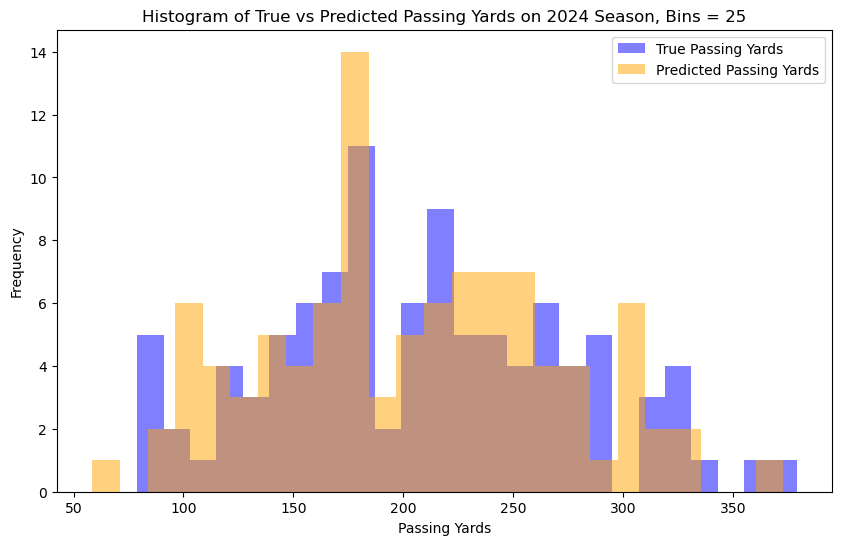

In [51]:

# Plotting the histogram of predicted passing yards and true passing yards
plt.figure(figsize=(10, 6))

# Plot histogram for true passing yards
plt.hist(pred_df['true_passing_yards'], bins=25, alpha=0.5, label='True Passing Yards', color='blue')

# Plot histogram for predicted passing yards
plt.hist(pred_df['predicted_passing_yards'], bins=25, alpha=0.5, label='Predicted Passing Yards', color='orange')

# Adding labels and title
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.title('Histogram of True vs Predicted Passing Yards on 2024 Season, Bins = 25')
plt.legend(loc='upper right')

# Show the plot
plt.show()

League-wide standard deviation of true passing yards: 68.44
Degrees of freedom (df) for J.Goff: 15
Probability of J.Goff throwing over or exactly 275 yards in Week 3: 0.1377
Probability of J.Goff throwing under or exactly 275 yards in Week 3: 0.8623
Custom Price for over 275 yards: +626
Custom Price for under 275 yards: -626


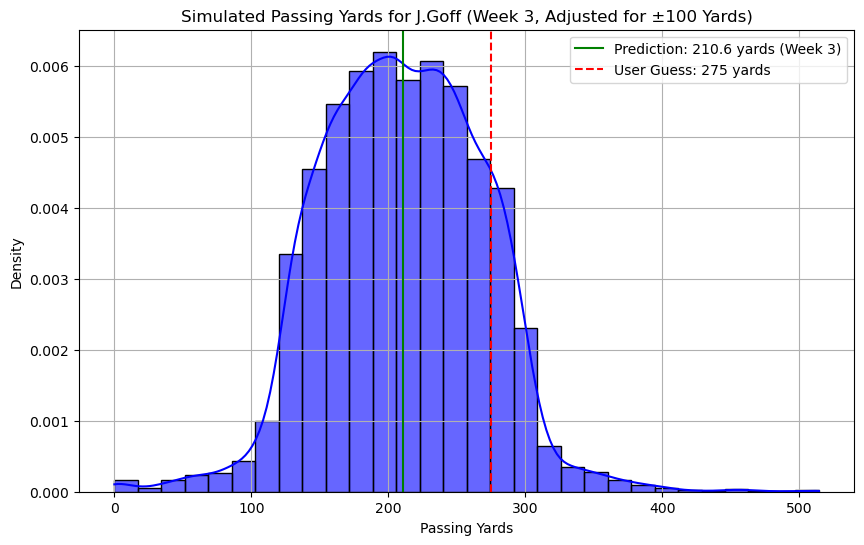

In [60]:
def simulate_passing_yards_adjusted(qb_name, week, pred_df, league_wide_std, num_simulations=10000, normal_weight=0.7, range_adjust=100):
    """
    Simulates passing yards using a combination of normal distribution and t-distribution,
    and adjusts the range to focus predictions around ±100 yards for sportsbook-like odds.
    """
    # Filter for the specific QB and week
    qb_data = pred_df[(pred_df['passer_player_name'] == qb_name) & (pred_df['week'] == week)]
    
    if qb_data.empty:
        print(f"No data found for {qb_name} in week {week}.")
        return None, None
    
    qb_data = qb_data.iloc[0]
    predicted_passing_yards = qb_data['predicted_passing_yards']
    residual_std = qb_data['residual_std']  # Use QB-specific standard deviation of residuals
    
    # Set degrees of freedom for t-distribution based on NFL passing trends
    if residual_std < 25:
        df = 15  # Lower variability, more consistent QB
    elif residual_std < 50:
        df = 10  # Moderate variability
    else:
        df = 7   # High variability, bigger tails
    
    print(f"Degrees of freedom (df) for {qb_name}: {df}")
    
    # Expand the standard deviation to focus on a ±100 yard range around the prediction
    expanded_std = range_adjust  # Adjusting the range to +-100 yards

    # Generate normal distribution simulations for values near the predicted passing yards
    normal_simulations = np.random.normal(loc=predicted_passing_yards, scale=expanded_std, size=num_simulations)
    
    # Generate t-distribution simulations for tail values
    t_distribution_simulations = stats.t.rvs(df, loc=predicted_passing_yards, scale=league_wide_std, size=num_simulations)
    
    # Combine the two distributions, with a smooth weighting between them
    combined_simulations = np.where(np.abs(normal_simulations - predicted_passing_yards) <= expanded_std, 
                                    normal_simulations * normal_weight + t_distribution_simulations * (1 - normal_weight),
                                    t_distribution_simulations)
    
    # Clip negative values (set minimum passing yards to 0 or reasonable floor)
    combined_simulations = np.clip(combined_simulations, 0, np.inf)
    
    return combined_simulations, predicted_passing_yards, df


def plot_qb_simulation_adjusted(qb_name, week, pred_df, league_wide_std, user_guess=None, num_simulations=10000, normal_weight=0.7, range_adjust=100):
    """
    Plots the distribution (curve) of simulated passing yards based on NFL trends for sportsbook-like odds,
    and calculates the custom price for both over and under the user guess with adjusted range for tighter predictions.
    """
    # Get the simulated passing yards, predicted passing yards, and degrees of freedom for the QB and week
    simulations, predicted_passing_yards, df = simulate_passing_yards_adjusted(qb_name, week, pred_df, league_wide_std, num_simulations, normal_weight, range_adjust)
    
    if simulations is None:
        return None, None
    
    # Plot the distribution of the simulated passing yards
    plt.figure(figsize=(10, 6))
    sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
    # Add the predicted passing yards line
    plt.axvline(predicted_passing_yards, color='green', linestyle='-', label=f"Prediction: {predicted_passing_yards:.1f} yards (Week {week})")
    
    # Add the user guess line and calculate the probability
    probability_at_least = None
    probability_at_most = None
    if user_guess is not None:
        plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
        
        # Calculate the probability of exceeding the user guess (at least)
        probability_at_least = np.mean(simulations >= user_guess)
        print(f"Probability of {qb_name} throwing over or exactly {user_guess} yards in Week {week}: {probability_at_least:.4f}")
        
        # Calculate the probability of being at most the user guess
        probability_at_most = 1 - probability_at_least
        print(f"Probability of {qb_name} throwing under or exactly {user_guess} yards in Week {week}: {probability_at_most:.4f}")
        
        # Calculate custom prices for over and under using the provided logic
        price_at_least = calculate_custom_price(probability_at_least)
        price_at_most = calculate_custom_price(probability_at_most)
        print(f"Custom Price for over {user_guess} yards: {price_at_least}")
        print(f"Custom Price for under {user_guess} yards: {price_at_most}")
    
    # Plot details
    plt.title(f"Simulated Passing Yards for {qb_name} (Week {week}, Adjusted for ±100 Yards)")
    plt.xlabel("Passing Yards")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return simulations, probability_at_least, probability_at_most, price_at_least, price_at_most

# Example usage:
if __name__ == "__main__":
    qb_name = "J.Goff"
    week = 3  # Example week
    user_guess = 275  # Example user guess for passing yards
    
    # Calculate league-wide standard deviation for fallback use
    league_wide_std = calculate_league_wide_std(pred_df)
    
    # Plot the NFL trend curve for the QB and calculate custom prices, adjusting for tighter range predictions
    simulations, probability_at_least, probability_at_most, price_at_least, price_at_most = plot_qb_simulation_adjusted(qb_name, week, pred_df, league_wide_std, user_guess=user_guess, normal_weight=0.9, range_adjust=100)

League-wide standard deviation of true passing yards: 68.44
Degrees of freedom (df) for J.Allen: 15
Probability of J.Allen throwing over or exactly 275 yards in Week 3: 0.3887
Probability of J.Allen throwing under or exactly 275 yards in Week 3: 0.6113
Custom Price for over 275 yards: +157
Custom Price for under 275 yards: -157


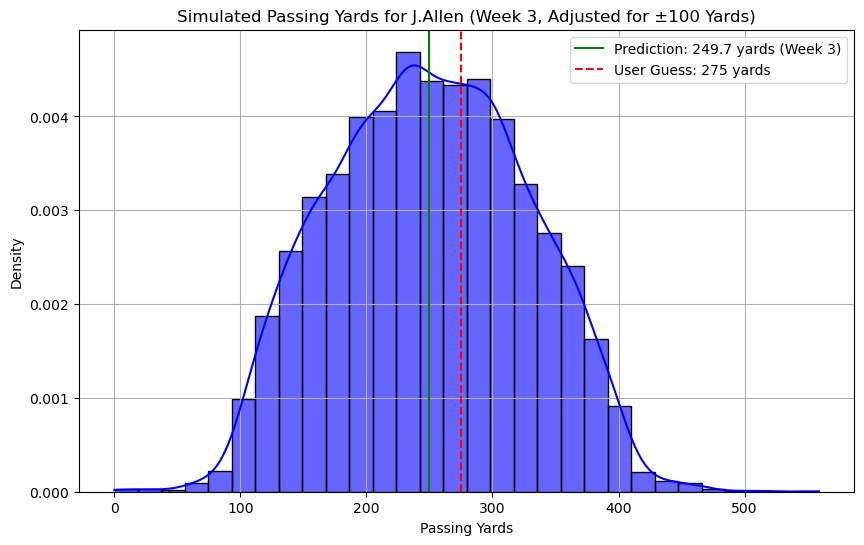

In [53]:
def simulate_passing_yards_adjusted(qb_name, week, pred_df, league_wide_std, num_simulations=10000, normal_weight=0.7, range_adjust=100, seed=31):
    """
    Simulates passing yards using a combination of normal distribution and t-distribution,
    and adjusts the range to focus predictions around ±100 yards for sportsbook-like odds.
    """

    """
    Simulates passing yards using a combination of normal distribution and t-distribution,
    and adjusts the range to focus predictions around ±100 yards for sportsbook-like odds.
    A random seed can be passed in for reproducible results.
    """
    if seed is not None:
        np.random.seed(seed)  # Set the random seed for reproducibility
    
    # Filter for the specific QB and week
    qb_data = pred_df[(pred_df['passer_player_name'] == qb_name) & (pred_df['week'] == week)]
    
    if qb_data.empty:
        print(f"No data found for {qb_name} in week {week}.")
        return None, None
    
    qb_data = qb_data.iloc[0]
    predicted_passing_yards = qb_data['predicted_passing_yards']
    residual_std = qb_data['residual_std']  # Use QB-specific standard deviation of residuals
    
    # Set degrees of freedom for t-distribution based on NFL passing trends
    if residual_std < 25:
        df = 15  # Lower variability, more consistent QB
    elif residual_std < 50:
        df = 10  # Moderate variability
    else:
        df = 7   # High variability, bigger tails
    
    print(f"Degrees of freedom (df) for {qb_name}: {df}")
    
    # Expand the standard deviation to focus on a ±100 yard range around the prediction
    expanded_std = range_adjust  # Adjusting the range to +-100 yards

    # Generate normal distribution simulations for values near the predicted passing yards
    normal_simulations = np.random.normal(loc=predicted_passing_yards, scale=expanded_std, size=num_simulations)
    
    # Generate t-distribution simulations for tail values
    t_distribution_simulations = stats.t.rvs(df, loc=predicted_passing_yards, scale=league_wide_std, size=num_simulations)
    
    # Combine the two distributions, with a smooth weighting between them
    combined_simulations = np.where(np.abs(normal_simulations - predicted_passing_yards) <= expanded_std, 
                                    normal_simulations * normal_weight + t_distribution_simulations * (1 - normal_weight),
                                    t_distribution_simulations)
    
    # Clip negative values (set minimum passing yards to 0 or reasonable floor)
    combined_simulations = np.clip(combined_simulations, 0, np.inf)
    
    return combined_simulations, predicted_passing_yards, df

def calculate_custom_price(probability):
    """
    Calculate a custom price based on the given probability using American odds logic.
    :param probability: The probability of an event (e.g., over/under on passing yards).
    :return: Formatted price in the form of American odds.
    """
    # Handle edge cases where probability is zero or near 1 (avoiding division by zero)
    if probability <= 0:
        return None
    elif probability >= 1:
        return "-100"  # Near certainty results in a very small return

    # Different formula based on whether the probability represents a favorite or underdog
    if probability >= 0.5:
        # For probabilities > 50%, use negative odds (favorites)
        price = -100 * (probability / (1 - probability))
    else:
        # For probabilities < 50%, use positive odds (underdogs)
        price = (100 / probability) - 100

    return "{:+.0f}".format(price)  # Format as integer with "+" or "-" sign

def plot_qb_simulation_adjusted(qb_name, week, pred_df, league_wide_std, user_guess=None, num_simulations=10000, normal_weight=0.7, range_adjust=100):
    """
    Plots the distribution (curve) of simulated passing yards based on NFL trends for sportsbook-like odds,
    and calculates the custom price for both over and under the user guess with adjusted range for tighter predictions.
    """
    # Get the simulated passing yards, predicted passing yards, and degrees of freedom for the QB and week
    simulations, predicted_passing_yards, df = simulate_passing_yards_adjusted(qb_name, week, pred_df, league_wide_std, num_simulations, normal_weight, range_adjust)
    
    if simulations is None:
        return None, None
    
    # Plot the distribution of the simulated passing yards
    plt.figure(figsize=(10, 6))
    sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
    # Add the predicted passing yards line
    plt.axvline(predicted_passing_yards, color='green', linestyle='-', label=f"Prediction: {predicted_passing_yards:.1f} yards (Week {week})")
    
    # Add the user guess line and calculate the probability
    probability_at_least = None
    probability_at_most = None
    if user_guess is not None:
        plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
        
        # Calculate the probability of exceeding the user guess (at least)
        probability_at_least = np.mean(simulations >= user_guess)
        print(f"Probability of {qb_name} throwing over or exactly {user_guess} yards in Week {week}: {probability_at_least:.4f}")
        
        # Calculate the probability of being at most the user guess
        probability_at_most = 1 - probability_at_least
        print(f"Probability of {qb_name} throwing under or exactly {user_guess} yards in Week {week}: {probability_at_most:.4f}")
        
        # Calculate custom prices for over and under using adjusted logic
        price_at_least = calculate_custom_price(probability_at_least)
        price_at_most = calculate_custom_price(probability_at_most)
        print(f"Custom Price for over {user_guess} yards: {price_at_least}")
        print(f"Custom Price for under {user_guess} yards: {price_at_most}")
    
    # Plot details
    plt.title(f"Simulated Passing Yards for {qb_name} (Week {week}, Adjusted for ±100 Yards)")
    plt.xlabel("Passing Yards")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return simulations, probability_at_least, probability_at_most, price_at_least, price_at_most

# Example usage:
if __name__ == "__main__":
    qb_name = "J.Allen"
    week = 3  # Example week
    user_guess = 275  # Example user guess for passing yards
    
    # Calculate league-wide standard deviation for fallback use
    league_wide_std = calculate_league_wide_std(pred_df)
    
    # Plot the NFL trend curve for the QB and calculate custom prices, adjusting for tighter range predictions
    simulations, probability_at_least, probability_at_most, price_at_least, price_at_most = plot_qb_simulation_adjusted(qb_name, week, pred_df, league_wide_std, user_guess=user_guess, normal_weight=0.8, range_adjust=180)

Probability of J.Allen throwing over or exactly 290 yards in Week 3: 0.0012
Probability of J.Allen throwing under or exactly 290 yards in Week 3: 0.9988
Price for over 290 yards: +83233
Price for under 290 yards: -83233


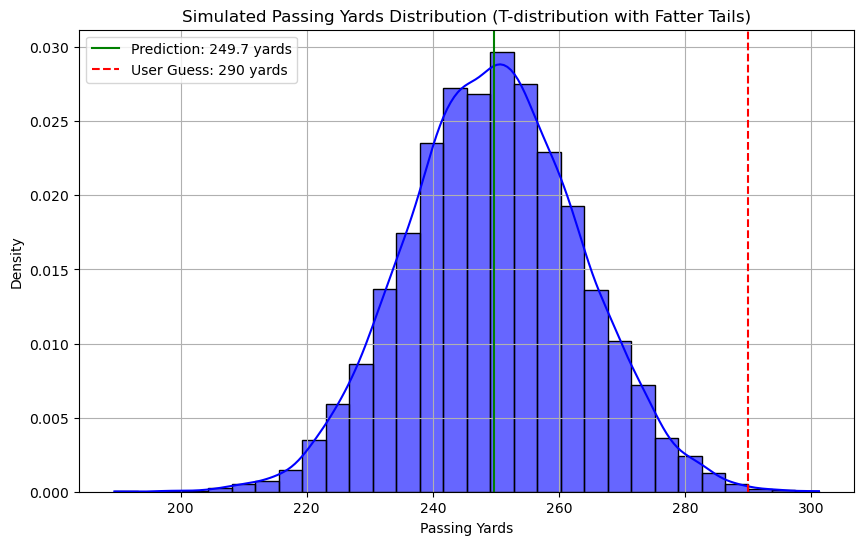

In [85]:
def simulate_passing_yards_fat_tails(predicted_yards, residual_std, num_simulations=10000, df=6, seed=42):
    """
    Simulates passing yards using a t-distribution to allow for fatter tails
    and more realistic variability in passing yards.
    
    :param predicted_yards: The predicted passing yards from the model.
    :param residual_std: The standard deviation of residuals (errors) from the model.
    :param num_simulations: Number of simulations to run.
    :param df: Degrees of freedom for the t-distribution (lower df = fatter tails).
    :param seed: Random seed for reproducibility.
    
    :return: Simulated passing yards as an array.
    """
    np.random.seed(seed)
    
    # Simulate passing yards using a t-distribution (heavier tails than normal distribution)
    simulations = stats.t.rvs(df, loc=predicted_yards, scale=residual_std, size=num_simulations)
    
    # Clip negative passing yards to 0 (as passing yards can't be negative)
    simulations = np.clip(simulations, 0, np.inf)
    
    return simulations

def calculate_probability(simulations, user_guess):
    """
    Calculate the probability of passing yards being over or under the user-specified value.
    """
    probability_at_least = np.mean(simulations >= user_guess)
    probability_at_most = 1 - probability_at_least
    
    return probability_at_least, probability_at_most

def calculate_american_odds(probability):
    """
    Convert a probability to American odds.
    """
    if probability >= 0.5:
        # Negative odds for favorites (probability > 50%)
        odds = -100 * (probability / (1 - probability))
    else:
        # Positive odds for underdogs (probability < 50%)
        odds = (100 / probability) - 100
    
    return f"{odds:+.0f}"

def plot_simulation_distribution(simulations, predicted_yards, user_guess):
    """
    Plot the distribution of simulated passing yards and highlight the user guess.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot the distribution of simulated passing yards
    sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
    # Add a line for the predicted passing yards
    plt.axvline(predicted_yards, color='green', linestyle='-', label=f"Prediction: {predicted_yards:.1f} yards")
    
    # Add a line for the user guess
    plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
    
    plt.title('Simulated Passing Yards Distribution (T-distribution with Fatter Tails)')
    plt.xlabel('Passing Yards')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

def run_monte_carlo_market_fat_tails(qb_name, week, pred_df, user_guess, num_simulations=10000, df=6):
    """
    Run the Monte Carlo simulation using predicted passing yards and residual standard deviation
    from the predictions DataFrame for the specified QB and week, calculate probabilities, 
    and assign American odds for over/under bets using a t-distribution with fatter tails.
    
    :param df: Degrees of freedom for the t-distribution (lower df = fatter tails).
    """
    # Filter the DataFrame for the specified QB and week
    qb_data = pred_df[(pred_df['passer_player_name'] == qb_name) & (pred_df['week'] == week)]
    
    if qb_data.empty:
        print(f"No data found for {qb_name} in Week {week}.")
        return None, None
    
    # Extract the predicted passing yards and residual standard deviation
    predicted_yards = qb_data['predicted_passing_yards'].values[0]
    residual_std = qb_data['residual_std'].values[0]  # Assuming residual_std is in pred_df
    
    # Step 1: Simulate passing yards with fatter tails
    simulations = simulate_passing_yards_fat_tails(predicted_yards, residual_std, num_simulations, df)
    
    # Step 2: Calculate probabilities for over/under the user guess
    probability_at_least, probability_at_most = calculate_probability(simulations, user_guess)
    
    # Step 3: Convert probabilities to American odds
    price_at_least = calculate_american_odds(probability_at_least)
    price_at_most = calculate_american_odds(probability_at_most)
    
    # Step 4: Print probabilities and prices
    print(f"Probability of {qb_name} throwing over or exactly {user_guess} yards in Week {week}: {probability_at_least:.4f}")
    print(f"Probability of {qb_name} throwing under or exactly {user_guess} yards in Week {week}: {probability_at_most:.4f}")
    print(f"Price for over {user_guess} yards: {price_at_least}")
    print(f"Price for under {user_guess} yards: {price_at_most}")
    
    # Step 5: Plot the distribution
    plot_simulation_distribution(simulations, predicted_yards, user_guess)

# Example usage:
if __name__ == "__main__":
    qb_name = "J.Allen"  # Example quarterback name
    week = 3  # Example week
    user_guess = 290  # Example user guess for passing yards
    
    # Run the Monte Carlo market using a t-distribution with fatter tails
    run_monte_carlo_market_fat_tails(qb_name, week, pred_df, user_guess, df=90)

Probability of D.Prescott throwing over or exactly 270 yards in Week 3: 0.9998
Probability of D.Prescott throwing under or exactly 270 yards in Week 3: 0.0002
Price for over 270 yards: -499900
Price for under 270 yards: +499900


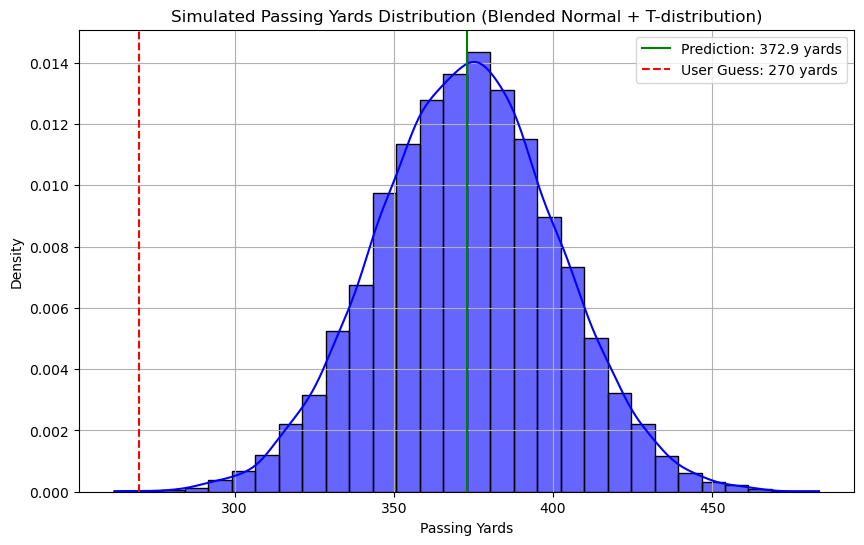

In [94]:
### Strategy 1: Blended Normal and T-Distribution ###
def blend_distributions(predicted_yards, residual_std, num_simulations=10000, df=40, blend_weight=0.8, seed=42):
    """
    Blends a normal distribution (for center) and t-distribution (for tails) to simulate passing yards.
    
    :param predicted_yards: Predicted passing yards from the model.
    :param residual_std: Standard deviation of residuals from the model's predictions.
    :param num_simulations: Number of Monte Carlo simulations to run.
    :param df: Degrees of freedom for the t-distribution (lower df = fatter tails).
    :param blend_weight: Weight for blending the normal and t-distributions (0 to 1).
    :param seed: Random seed for reproducibility.
    
    :return: Simulated passing yards as an array.
    """
    np.random.seed(seed)
    
    # Simulate a normal distribution for central values
    normal_simulations = np.random.normal(loc=predicted_yards, scale=residual_std, size=num_simulations)
    
    # Simulate a t-distribution for tail values
    t_distribution_simulations = stats.t.rvs(df, loc=predicted_yards, scale=residual_std, size=num_simulations)
    
    # Blend the two distributions
    blended_simulations = blend_weight * normal_simulations + (1 - blend_weight) * t_distribution_simulations
    
    # Clip negative values
    blended_simulations = np.clip(blended_simulations, 0, np.inf)
    
    return blended_simulations

### Strategy 2: Dynamic Standard Deviation Adjustment ###
def dynamic_std_adjust(predicted_yards, user_guess, base_std, factor=1.5):
    """
    Adjusts the standard deviation based on how far the user's guess is from the predicted value.
    
    :param predicted_yards: Predicted passing yards from the model.
    :param user_guess: User's guess for passing yards.
    :param base_std: Base standard deviation from the model.
    :param factor: Multiplier to expand the standard deviation dynamically.
    
    :return: Adjusted standard deviation.
    """
    # Calculate how far the user's guess is from the predicted yards
    distance_from_prediction = np.abs(user_guess - predicted_yards)
    
    # Expand the standard deviation based on the distance from the prediction
    adjusted_std = base_std * (1 + (distance_from_prediction / predicted_yards) * factor)
    
    return adjusted_std

### Strategy 3: Dynamic Degrees of Freedom for T-distribution ###
def dynamic_t_distribution(df_base, residual_std, scale_factor=2):
    """
    Adjusts the degrees of freedom (df) for the t-distribution based on the QB's residual standard deviation.
    
    :param df_base: Base degrees of freedom for a typical QB.
    :param residual_std: Standard deviation of residuals (QB-specific).
    :param scale_factor: Multiplier to adjust df based on variability.
    
    :return: Adjusted degrees of freedom for t-distribution.
    """
    return df_base + (residual_std / scale_factor)

### Run Monte Carlo Market Using the Strategies ###
def run_monte_carlo_market_strategies(qb_name, week, pred_df, user_guess, num_simulations=10000, df_base=40, blend_weight=0.8, factor=1.5):
    """
    Run the Monte Carlo simulation using the blended distribution, dynamic standard deviation, and dynamic degrees of freedom
    to simulate passing yards and assign realistic probabilities and odds for over/under bets.
    """
    # Filter the DataFrame for the specified QB and week
    qb_data = pred_df[(pred_df['passer_player_name'] == qb_name) & (pred_df['week'] == week)]
    
    if qb_data.empty:
        print(f"No data found for {qb_name} in Week {week}.")
        return None, None
    
    # Extract the predicted passing yards and residual standard deviation
    predicted_yards = qb_data['predicted_passing_yards'].values[0]
    residual_std = qb_data['residual_std'].values[0]  # Assuming residual_std is in pred_df
    
    # Step 1: Adjust the standard deviation dynamically based on the user's guess
    adjusted_std = dynamic_std_adjust(predicted_yards, user_guess, residual_std, factor=factor)
    
    # Step 2: Adjust the degrees of freedom for the t-distribution based on the residuals
    df = dynamic_t_distribution(df_base, residual_std)
    
    # Step 3: Simulate passing yards using the blended distribution (normal + t-distribution)
    simulations = blend_distributions(predicted_yards, adjusted_std, num_simulations, df=df, blend_weight=blend_weight)
    
    # Step 4: Calculate probabilities for over/under the user guess
    probability_at_least = np.mean(simulations >= user_guess)
    probability_at_most = 1 - probability_at_least
    
    # Step 5: Convert probabilities to American odds
    price_at_least = calculate_american_odds(probability_at_least)
    price_at_most = calculate_american_odds(probability_at_most)
    
    # Step 6: Print probabilities and prices
    print(f"Probability of {qb_name} throwing over or exactly {user_guess} yards in Week {week}: {probability_at_least:.4f}")
    print(f"Probability of {qb_name} throwing under or exactly {user_guess} yards in Week {week}: {probability_at_most:.4f}")
    print(f"Price for over {user_guess} yards: {price_at_least}")
    print(f"Price for under {user_guess} yards: {price_at_most}")
    
    # Step 7: Plot the distribution
    plot_simulation_distribution(simulations, predicted_yards, user_guess)

### Helper Functions ###
def calculate_american_odds(probability):
    """
    Convert a probability to American odds.
    """
    if probability >= 0.5:
        # Negative odds for favorites (probability > 50%)
        odds = -100 * (probability / (1 - probability))
    else:
        # Positive odds for underdogs (probability < 50%)
        odds = (100 / probability) - 100
    
    return f"{odds:+.0f}"

def plot_simulation_distribution(simulations, predicted_yards, user_guess):
    """
    Plot the distribution of simulated passing yards and highlight the user guess.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot the distribution of simulated passing yards
    sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
    # Add a line for the predicted passing yards
    plt.axvline(predicted_yards, color='green', linestyle='-', label=f"Prediction: {predicted_yards:.1f} yards")
    
    # Add a line for the user guess
    plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
    
    plt.title('Simulated Passing Yards Distribution (Blended Normal + T-distribution)')
    plt.xlabel('Passing Yards')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
if __name__ == "__main__":
    qb_name = "D.Prescott"  # Example quarterback name
    week = 3  # Example week
    user_guess = 270  # Example user guess for passing yards
    
    # Run the Monte Carlo market using all strategies
    run_monte_carlo_market_strategies(qb_name, week, pred_df, user_guess, df_base=0.1, blend_weight=1.05, factor=1.5)